# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

In [2]:
import tensorflow as tf
import numpy as np
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [3]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 90.1M  100 90.1M    0     0  7396k      0  0:00:12  0:00:12 --:--:-- 7271k
total 96
-rw-rw-r-- 1 philou philou 29054 Jun 30 20:05 image_denoising.ipynb
drwx------ 2 philou philou 57344 Jun  9 15:06 paintings
-rw-rw-r-- 1 philou philou     0 Jun 29 09:17 README.md
drwxrwxr-x 2 philou philou  4096 Jun 30 15:39 tests


In [4]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings/Sandro_Botticelli_44.jpg',
 './paintings/Henri_Matisse_128.jpg',
 './paintings/Sandro_Botticelli_2.jpg',
 './paintings/Mikhail_Vrubel_84.jpg',
 './paintings/Paul_Gauguin_12.jpg',
 './paintings/Albrecht_Duâ\x95\xa0Ãªrer_17.jpg',
 './paintings/Alfred_Sisley_165.jpg',
 './paintings/Gustav_Klimt_63.jpg',
 './paintings/Pierre-Auguste_Renoir_324.jpg',
 './paintings/Paul_Klee_90.jpg',
 './paintings/Albrecht_DuÌ\x88rer_22.jpg',
 './paintings/Henri_Rousseau_21.jpg',
 './paintings/Pierre-Auguste_Renoir_230.jpg',
 './paintings/Michelangelo_49.jpg',
 './paintings/El_Greco_34.jpg',
 './paintings/Paul_Gauguin_245.jpg',
 './paintings/Giotto_di_Bondone_92.jpg',
 './paintings/Henri_de_Toulouse-Lautrec_31.jpg',
 './paintings/Pablo_Picasso_92.jpg',
 './paintings/Joan_Miro_48.jpg',
 './paintings/Henri_de_Toulouse-Lautrec_68.jpg',
 './paintings/Pablo_Picasso_70.jpg',
 './paintings/Henri_Rousseau_8.jpg',
 './paintings/Vincent_van_Gogh_875.jpg',
 './paintings/Paul_Gauguin_188.jpg',
 './paint

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

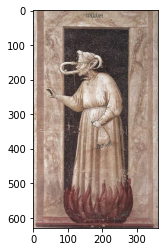

In [5]:
im = Image.open(dataset_paths[53])
plt.imshow(im);

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [6]:
dataset_paths[53]

'./paintings/Giotto_di_Bondone_85.jpg'

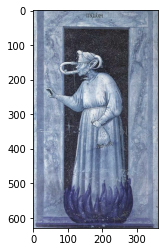

In [7]:
imcv = cv2.imread(dataset_paths[53])
plt.imshow(imcv);

In [8]:
imcv.shape

(629, 360, 3)

In [9]:
type(imcv)

numpy.ndarray

❓ **What was in the image above?**

In [10]:
img_shape = (629, 360)
img_dim = 3

# Uncomment the correct answer

is_portrait = True
#is_portrait = False

is_colored_image = True
#is_colored_image = False

In [11]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [12]:
len(dataset_paths)

1085

In [13]:
dataset_images = []
for i in range(len(dataset_paths)):
               dataset_images.append(cv2.imread(dataset_paths[i]))

In [14]:
dataset_images[53][0]

array([[181, 185, 203],
       [199, 203, 221],
       [200, 204, 222],
       ...,
       [139, 155, 171],
       [168, 184, 200],
       [111, 127, 143]], dtype=uint8)

In [15]:
len(dataset_images)

1085

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

- I notice that we have different image shapes : it makes sense as paintings are not of the same dimensions, same with images of these paintings.
- OpenCv already converted black and white images with 3 dimensions

In [16]:
images_shapes = [image.shape for image in dataset_images]
images_shapes[:10]

[(613, 614, 3),
 (423, 347, 3),
 (480, 319, 3),
 (453, 600, 3),
 (467, 583, 3),
 (614, 490, 3),
 (427, 614, 3),
 (608, 614, 3),
 (540, 438, 3),
 (362, 480, 3)]

In [17]:
ndims = set([shape[2] for shape in images_shapes])
ndims

{3}

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [18]:
from tqdm import tqdm

In [19]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:00<00:00, 2736512.23it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [20]:
# Check image shapes
images_shapes = [image.shape for image in dataset_images]
images_shapes[:10]

[(613, 614, 3),
 (423, 347, 3),
 (480, 319, 3),
 (453, 600, 3),
 (467, 583, 3),
 (614, 490, 3),
 (427, 614, 3),
 (608, 614, 3),
 (540, 438, 3),
 (362, 480, 3)]

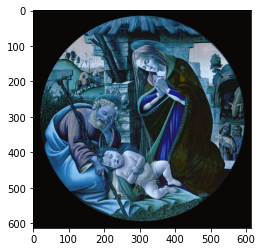

In [21]:
# Resize images with tensorflow - test 1 image
plt.imshow(dataset_images[0]);

(120, 100, 3)


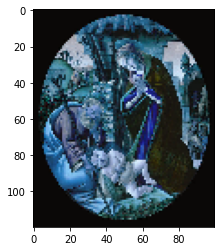

In [22]:
testimage = tf.image.resize(dataset_images[0],size=[120,100],method='nearest', preserve_aspect_ratio=False,
    antialias=True).numpy()
print(testimage.shape)
plt.imshow(testimage);

In [23]:
# Resize all images
dataset_resized = []
for i in range(len(dataset_images)):
    dataset_resized.append(tf.image.resize(dataset_images[i],size=[120,100],method='nearest', preserve_aspect_ratio=False,
    antialias=True).numpy())
dataset_resized = np.asarray(dataset_resized)
dataset_resized.shape

(1085, 120, 100, 3)

In [24]:
images_shapes_resized = [image.shape for image in dataset_resized]
print(len(images_shapes_resized))
set(images_shapes_resized)

1085


{(120, 100, 3)}

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

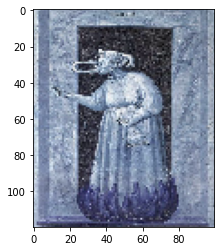

In [25]:
dataset_scaled = [image/255 for image in dataset_resized]
dataset_scaled = np.asarray(dataset_scaled)
plt.imshow(dataset_scaled[53]);

In [26]:
print(np.max(dataset_scaled))
print(np.min(dataset_scaled))
print(type(dataset_scaled))
print(dataset_scaled.shape)

1.0
0.0
<class 'numpy.ndarray'>
(1085, 120, 100, 3)


### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [27]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

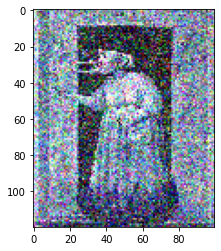

In [28]:
plt.imshow(dataset_noisy[53]);

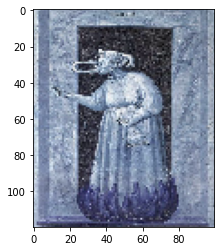

In [29]:
plt.imshow(dataset_scaled[53]);

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [30]:
X = dataset_noisy
Y = dataset_scaled

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [32]:
X_train.shape

(868, 120, 100, 3)

In [33]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [35]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [36]:
# Encoder with output shape equal to latent space
encoder = Sequential(name='encoder')
encoder.add(layers.Conv2D(16, kernel_size=3, activation='relu', padding="same", input_shape=(120, 100, 3)))
encoder.add(layers.MaxPooling2D(2))
encoder.add(layers.Conv2D(8, kernel_size=3, activation='relu', padding="same"))
encoder.add(layers.MaxPooling2D(2))
encoder.add(layers.Flatten())
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 120, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 25, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
Total params: 1,608
Trainable params: 1,608
Non-trainable params: 0
_________________________________________________________________


👉 **Test your encoder below**

In [37]:
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 6000)              1608      
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 8,283
Trainable params: 8,283
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [38]:
from tensorflow.keras.metrics import mean_absolute_error

In [39]:
# Compute basesline score (MAE between Y_test and X_test as if no de-noising at all)
score_baseline = np.mean(mean_absolute_error(Y_test, X_test))
score_baseline

0.141429237929893

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [40]:
# Compile autoencoder
autoencoder.compile(loss='mae',
                    optimizer='adam')

In [41]:
# Train autoencoder
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=4, restore_best_weights=True)

history = autoencoder.fit(X_train, Y_train,
                    validation_split=0.3,
                    batch_size=4,
                    epochs=250,
                    callbacks=[es],
                    verbose=1)

Epoch 1/250
152/152 [==============================] - 12s 75ms/step - loss: 0.1576 - val_loss: 0.1031
Epoch 2/250
152/152 [==============================] - 10s 65ms/step - loss: 0.0950 - val_loss: 0.0870
Epoch 3/250
152/152 [==============================] - 10s 66ms/step - loss: 0.0840 - val_loss: 0.0824
Epoch 4/250
152/152 [==============================] - 10s 65ms/step - loss: 0.0813 - val_loss: 0.0810
Epoch 5/250
152/152 [==============================] - 10s 66ms/step - loss: 0.0805 - val_loss: 0.0802
Epoch 6/250
152/152 [==============================] - 10s 64ms/step - loss: 0.0787 - val_loss: 0.0792
Epoch 7/250
152/152 [==============================] - 10s 65ms/step - loss: 0.0785 - val_loss: 0.0797
Epoch 8/250
152/152 [==============================] - 10s 67ms/step - loss: 0.0778 - val_loss: 0.0808
Epoch 9/250
152/152 [==============================] - 10s 66ms/step - loss: 0.0772 - val_loss: 0.0772
Epoch 10/250
152/152 [==============================] - 10s 66ms/step - l

❓ **Plot your training and validation loss at each epoch using the cell below**

In [83]:
# Plot below your train/val loss history


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

<Figure size 432x288 with 0 Axes>

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [45]:
Y_pred = autoencoder.predict(X_test)

In [80]:
score_test = np.mean(mean_absolute_error(Y_test, Y_pred))
score_test

0.06931696

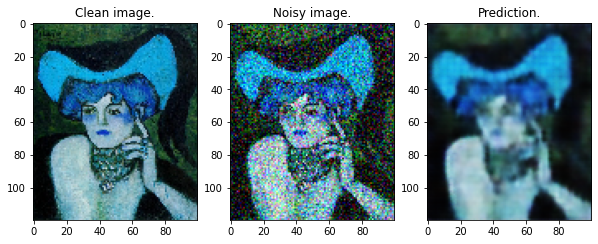

In [82]:
idx = 33

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

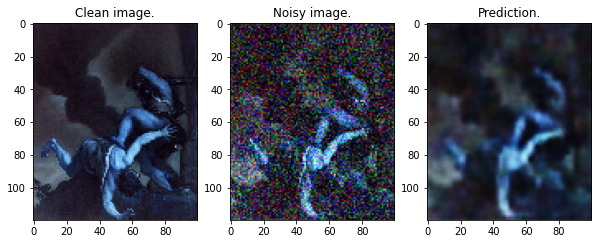

In [76]:
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [81]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()